In [1]:
import numpy as np
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def image_sample(Img, x, y, cval=0):
    shape = list(Img.shape)
    shape[0] += 1
    shape[1] += 1
    img = np.zeros(shape)
    img[:-1, :-1] = Img + 0
    assert x.shape == y.shape, 'Coordinates need to have the same shape'
    # sample img given fractional x and y
    H, W = Img.shape[:2]
    if len(img.shape) == 3:
        C = img.shape[2]
    else:
        C = 1
    outimg = np.zeros((*x.shape, C)) + cval 
    # Get valid coordinates
    valididx = (0 <= x)*(x <= W-1)*(0 <= y)*(y <= H-1)
    nullidx = ~valididx
    # for all valid coordinates, get the values of intensity
    xf = np.floor(x[valididx]).astype(int)
    xc = xf + 1
    yf = np.floor(y[valididx]).astype(int)
    yc = yf + 1
    _x, _y = x[valididx], y[valididx]
    # find values
    img_sampled =     img[yf, xf]*(yc - _y)*(xc - _x) \
                    + img[yf, xc]*(yc - _y)*(_x - xf) \
                    + img[yc, xf]*(_y - yf)*(xc - _x) \
                    + img[yc, xc]*(_y - yf)*(_x - xf) 
    if C == 1:
        outimg[valididx, 0] = img_sampled.squeeze()
    else:
        outimg[valididx] = img_sampled
    return outimg.squeeze()

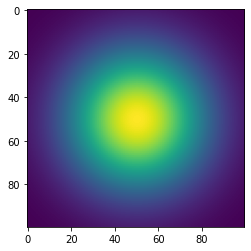

In [3]:
x = np.arange(100)
xx, yy = np.meshgrid(x, x)
img = exp((-(xx-50)**2 - (yy-50)**2)/1000)
# plt.figure(figsize=(14, 14))
plt.imshow(img)

In [4]:
xm = xx + np.random.randn(*xx.shape)
ym = yy + np.random.randn(*yy.shape)

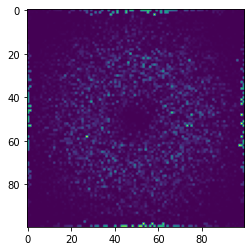

In [5]:
out = image_sample(img, xm, ym)
plt.imshow((out - img)**2)

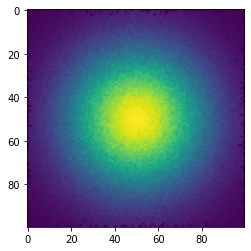

In [6]:
# plt.figure(figsize=(14, 14))
plt.imshow(out)

# Create some vessels
In the first part, we will create a straight vessel and create lambdas for each pixel

In [7]:
def create_straight_vessel(img_size=32, vessel_thickness=5, rotate=0):
    '''
    Given an image and vessel size, and rotation of vessel
    rotation is in degrees
    '''
    img = np.zeros((img_size, img_size))
    C = img_size // 2
    x = np.arange(img_size) - C
    xx, yy = np.meshgrid(x, x)
    # Get angle
    theta = rotate / 180 * pi
    sint = sin(theta)
    cost = cos(theta)
    # Get distance of each point from 
    dist = np.abs(sint*xx - cost*yy)
    vessel = (dist < vessel_thickness//2).astype(int)
    # Find vessel directions
    vx = cost + vessel*0
    vy = sint + vessel*0
    # find distance of each point
    r = vessel * 0
    for B in [C, -C]:
        # Same for x
        scale = (B - xx)/vx
        yt = yy + vy*scale
        idx = (-C <= yt)&(yt < C)
        _y, _x = np.where(idx)       
        idr = np.abs(scale[idx]) > np.abs(r[idx])
        # update the value of r
        r[_y[idr], _x[idr]] = scale[idx][idr] + 0
       
        # Same for y
        scale = (B - yy)/vy
        xt = xx + vx*scale
        idx = (-C <= xt)&(xt < C)
        _y, _x = np.where(idx)       
        idr = np.abs(scale[idx]) > np.abs(r[idx])
        # update the value of r
        r[_y[idr], _x[idr]] = scale[idx][idr] + 0      
    
    r = r
    # find perpendicular distance
    scale = np.abs(np.abs(dist) - vessel_thickness//2)
    vx1 = -vy*scale
    vy1 = vx*scale 
    # generate flows
    flowparallel = np.concatenate([vx[...,None], vy[..., None]], -1)
    flowper = np.concatenate([vx1[...,None], vy1[..., None]], -1)    
    
    return vessel, flowparallel, flowper, r
    

In [8]:
vessel, fparallel, fper, r = create_straight_vessel(50, vessel_thickness=5, rotate=30)

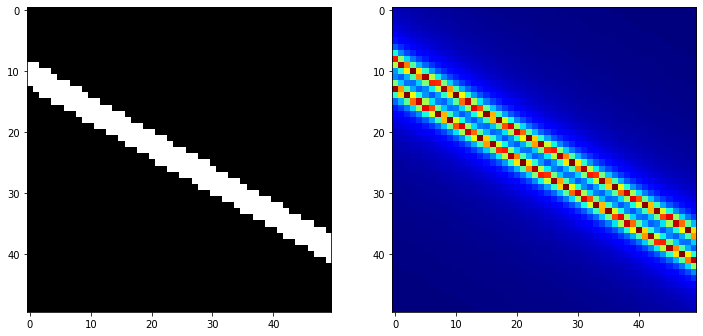

In [9]:
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(vessel, 'gray')
plt.subplot(122)
# plt.imshow(1./(1 + fper**2).sum(-1)) 1 / lambda_parallel  + 1./lam_per
plt.imshow(1./np.sqrt((1e-1 + fper**2).sum(-1)) + 1./np.sqrt((1e-1 + fparallel**2).sum(-1)), 'jet')

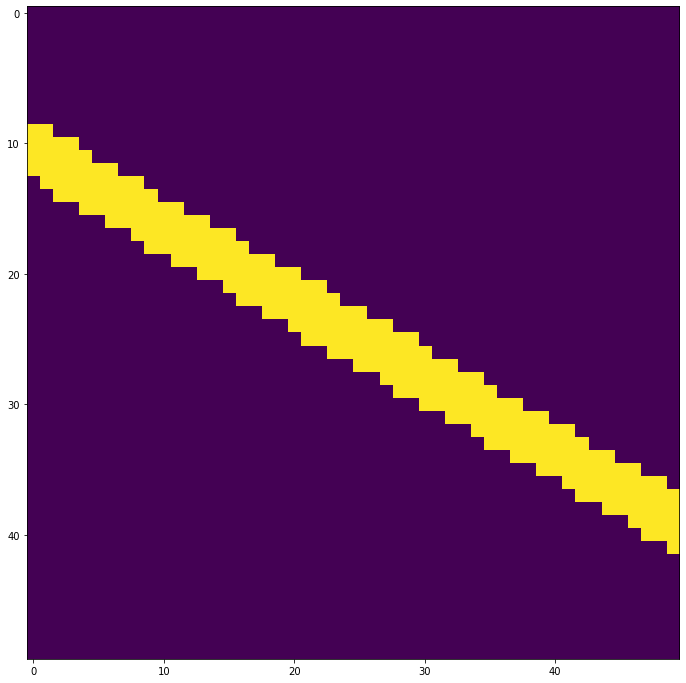

In [10]:
plt.figure(figsize=(12, 12))
plt.imshow(vessel)

## Changing thickness


In [11]:
def get_r(vx, vy, xx, yy, C):
    '''
    Given direction, coordinates and C
    '''
    r = xx*0
    for B in [C, -C]:
        # Same for x
        scale = (B - xx)/vx
        yt = yy + vy*scale
        idx = (-C <= yt)&(yt < C)
        _y, _x = np.where(idx)       
        idr = np.abs(scale[idx]) > np.abs(r[idx])
        # update the value of r
        r[_y[idr], _x[idr]] = scale[_y[idr], _x[idr]] + 0
        # Same for y
        scale = (B - yy)/vy
        xt = xx + vx*scale
        idx = (-C <= xt)&(xt < C)
        _y, _x = np.where(idx)       
        idr = np.abs(scale[idx]) > np.abs(r[idx])
        # update the value of r
        r[_y[idr], _x[idr]] = scale[_y[idr], _x[idr]] + 0
    return r

def changing_thickness_vessel(img_size=32, vessel_thickness=5, rotate=0, thickness_angle=0):
    '''
    Given an image and vessel size, and rotation of vessel
    rotation is in degrees
    '''
    img = np.zeros((img_size, img_size))
    C = img_size // 2
    x = np.arange(img_size) - C
    xx, yy = np.meshgrid(x, x)
    # Get angle
    theta = rotate / 180 * pi
    t_angle = thickness_angle/180*pi
    sint = sin(theta)
    cost = cos(theta)
    # Get distance of each point from origin
    dist = np.abs(sint*xx - cost*yy)
    distper = cost*xx + sint*yy
    # Save the vessel subvalues
    ves1 = ((dist < np.sqrt(2)*vessel_thickness//2)*(distper < 0)).astype(int)
    vessel = ves1 + 0
    V = []
    for s in [-1, 1]:
        _sint = sin(theta + s*t_angle)
        _cost = cos(theta + s*t_angle)
        _dist = np.abs(_sint*xx - cost*yy)
        _v = ((_dist < vessel_thickness//2)*(distper > -1)).astype(int)
        V.append(_v + 0)
        vessel = vessel + _v
    vessel = (vessel > 0).astype(int)
    ves2, ves3 = V
    # Find vessel directions
    vx = cost + vessel*0
    vy = sint + vessel*0
    # find distance of each point
    r = get_r(vx, vy, xx, yy, C)
    scale = np.abs(np.abs(dist) - np.sqrt(2)*vessel_thickness//2)
    scale[np.where(distper > -1)] = np.max(scale)
    for s in [-1, 1]:
        _sint = sin(theta + s*t_angle)
        _cost = cos(theta + s*t_angle)
        _dist = np.abs(_sint*xx - _cost*yy)
        _r = get_r(_cost + xx*0, _sint + xx*0, xx, yy, C)
        _y, _x = np.where((_dist < vessel_thickness)*(distper > -1))
        r[_y, _x] = _r[_y, _x]
        # Change vx and vy as per the direction of bifurcations
        vx[_y, _x] = _cost
        vy[_y, _x] = _sint
        scale[_y, _x] = np.minimum(scale[_y,_x], np.abs(np.abs(_dist) - vessel_thickness//2)[_y, _x])
    # find perpendicular distance
    vx1 = -vy*scale
    vy1 = vx*scale 
    # generate flows
    flowparallel = np.concatenate([vx[...,None], vy[..., None]], -1)
    flowper = np.concatenate([vx1[...,None], vy1[..., None]], -1)    
    
    return vessel, flowparallel, flowper, r

In [12]:
vessel, fparallel, fper, r = changing_thickness_vessel(32, vessel_thickness=5, rotate=50, thickness_angle=50)

/home/rohitrango/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/rohitrango/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/rohitrango/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal
/home/rohitrango/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


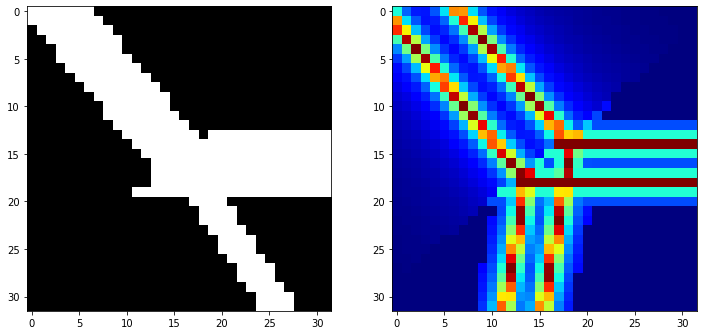

In [13]:
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(vessel, 'gray')
plt.subplot(122)
# plt.imshow(1./(1 + fper**2).sum(-1)) 1 / lambda_parallel  + 1./lam_per
plt.imshow(1./np.sqrt((1e-1 + fper**2).sum(-1)) + 1./np.sqrt((1e-1 + fparallel**2).sum(-1)), 'jet')

In [14]:
def curved_vessel(img_size=32, vessel_thickness=5, curvature=1, rotate=0):
    '''
    Given an image and vessel size, and curvature of vessel
    rotation is in degrees
    '''
    if curvature == 0:
        return create_straight_vessel(img_size, vessel_thickness, rotate=rotate)
    img = np.zeros((img_size, img_size))
    C = img_size // 2
    x = np.arange(img_size) - C
    xx, yy = np.meshgrid(x, x)
    # Get coordinate
    rad = C / curvature
    # Get center otherwise
    angle = rotate * pi / 180
    cx = cos(angle)*rad
    cy = sin(angle)*rad
    # Given these points, just return vessel
    vessel = exp(-np.abs((xx - cx)**2 + (yy - cy)**2 - rad**2)/2/(C)**2)
    # Determine intensity for thickness of vessel
    oy, ox = np.where((xx == 0)&(yy == 0))
    angles = np.linspace(0, 2*pi, 100)
    ay = oy + sin(angles)*vessel_thickness//2
    ax = ox + cos(angles)*vessel_thickness//2
    ivals = image_sample(vessel, ax, ay)
    thres = np.min(ivals)
    # Return vessel
    V = vessel > thres
    scale = np.abs(np.sqrt((xx - cx)**2 + (yy - cy)**2) - rad)
    r = np.minimum(np.abs(scale - vessel_thickness//2), np.abs(scale + vessel_thickness//2))
    return V, r

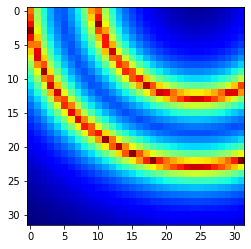

In [15]:
vessel, r = curved_vessel(vessel_thickness=10, curvature=0.8, rotate=-65)
plt.imshow(1/(2 + r), 'jet')

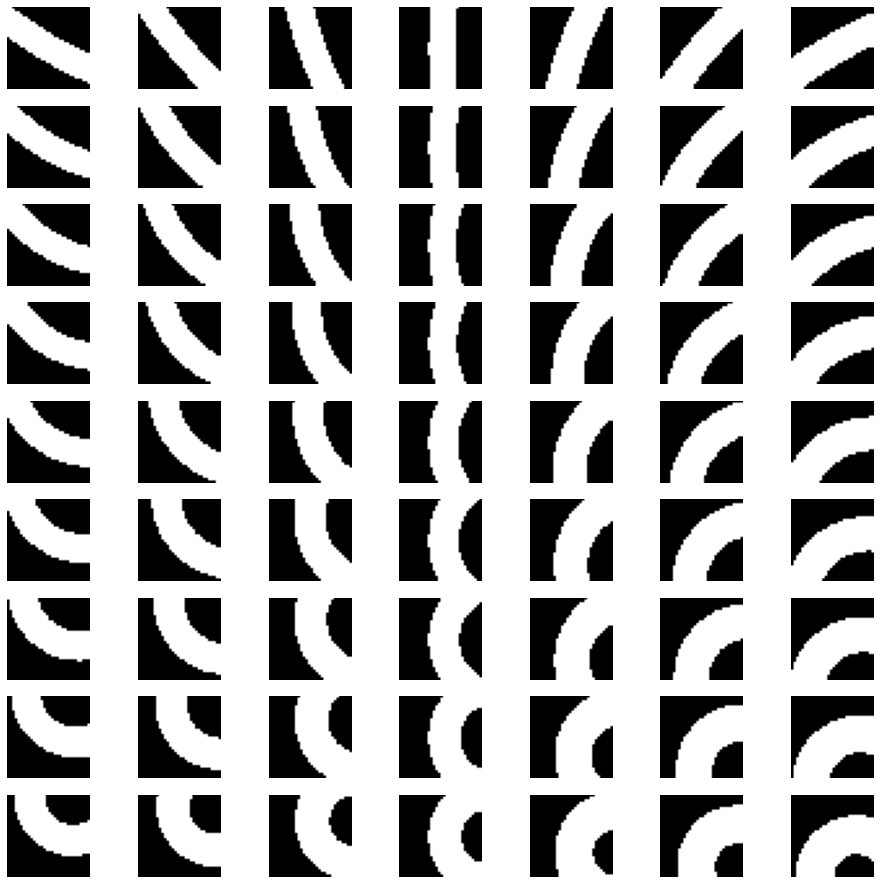

In [16]:
idx = 1
plt.figure(figsize=(16, 16))
for curv in np.arange(0.1, 1, 0.1):
    for rotate in np.arange(-60, 80, 20):
        plt.subplot(9, 7, idx)
        v, r = curved_vessel(vessel_thickness=10, curvature=curv, rotate=rotate)
#         plt.imshow(1/(2+r), 'jet')
        plt.imshow(v, 'gray')
        plt.axis('off')
        idx+=1

In [17]:
idx

64

In [18]:
def create_slant_vessel(img_size=32, vessel_thickness=5, rotate=0, local_rotate=0):
    '''
    Given an image and vessel size, and rotation of vessel
    rotation is in degrees
    '''
    img = np.zeros((img_size, img_size))
    C = img_size // 2
    x = np.arange(img_size) - C
    xx, yy = np.meshgrid(x, x)
    # Get angle
    theta = rotate / 180 * pi
    theta2 = local_rotate / 180 * pi
    sint = sin(theta)
    cost = cos(theta)
    # Get distance of each point from 
    dist1 = sin(theta + theta2)*xx - cos(theta + theta2)*yy
    dist2 = sin(theta - theta2)*xx - cos(theta - theta2)*yy
    vessel1 = (dist1 < vessel_thickness//2).astype(int)
    vessel2 = (dist2 > -vessel_thickness//2).astype(int)
    vessel = vessel1*vessel2
    return vessel

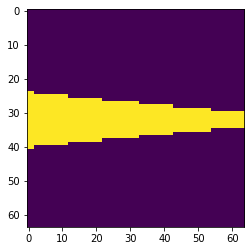

In [19]:
plt.imshow(create_slant_vessel(64, rotate=0, vessel_thickness=10, local_rotate=5.5))

(-0.5, 63.5, 63.5, -0.5)

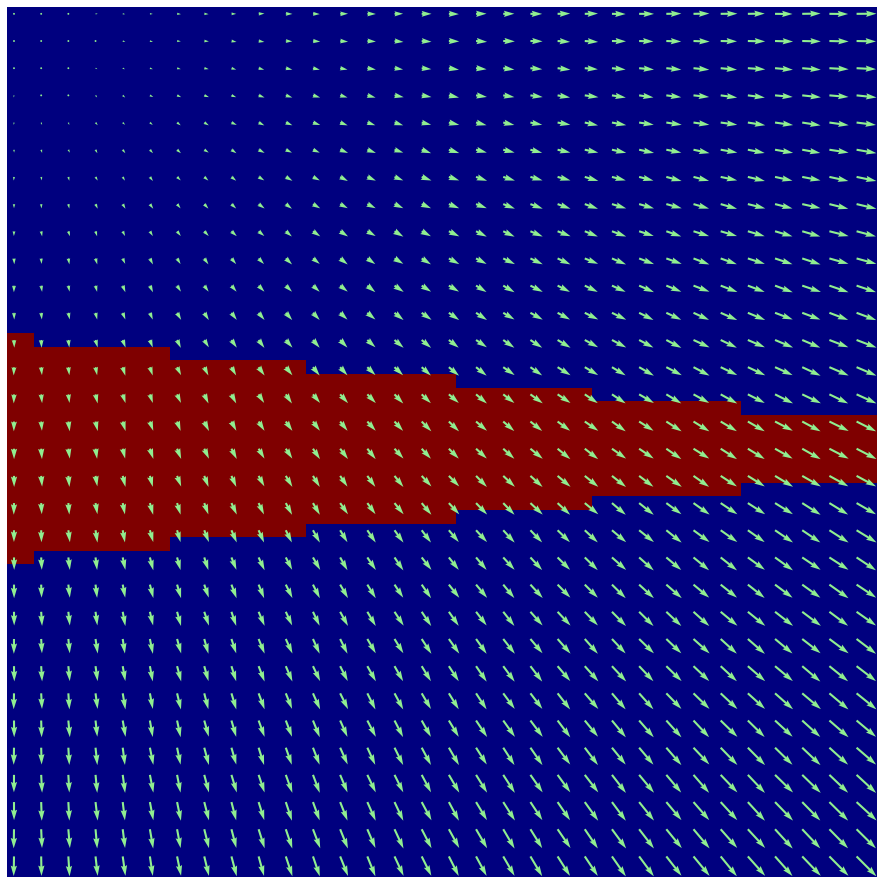

In [20]:
plt.figure(figsize=(16, 16))
plt.imshow(create_slant_vessel(64, rotate=0, vessel_thickness=10, local_rotate=5.5), cmap='jet')
# Get arrows
flow = np.random.randn(64, 64, 2)
flow = flow/(np.sqrt((flow**2).sum(-1))[..., None] + 1e-10)
# Get x,y
s = 2
x = np.arange(64)
xx, yy = np.meshgrid(x, x)
xx = xx[::s, ::s]
yy = yy[::s, ::s]
flow = flow[::s, ::s]

# Get color
color = np.arctan2(flow[...,1]+yy, flow[...,0]+xx)
# color = (color - color.min())/(color.max() - color.min())
plt.quiver(xx, yy, flow[:,:,0]+xx, flow[:,:,1]-yy, color='lightgreen', )
plt.axis('off')
# plt.savefig('tmp.png', bbox_inches='tight')

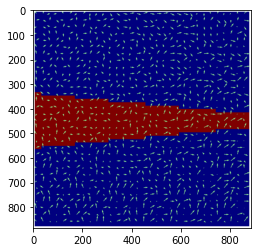

In [21]:
from PIL import Image
_a_ = Image.open('tmp.png')
plt.imshow(np.array(_a_))

In [22]:
np.array(_a_).shape

(884, 884, 4)

(-0.5, 883.5, 883.5, -0.5)

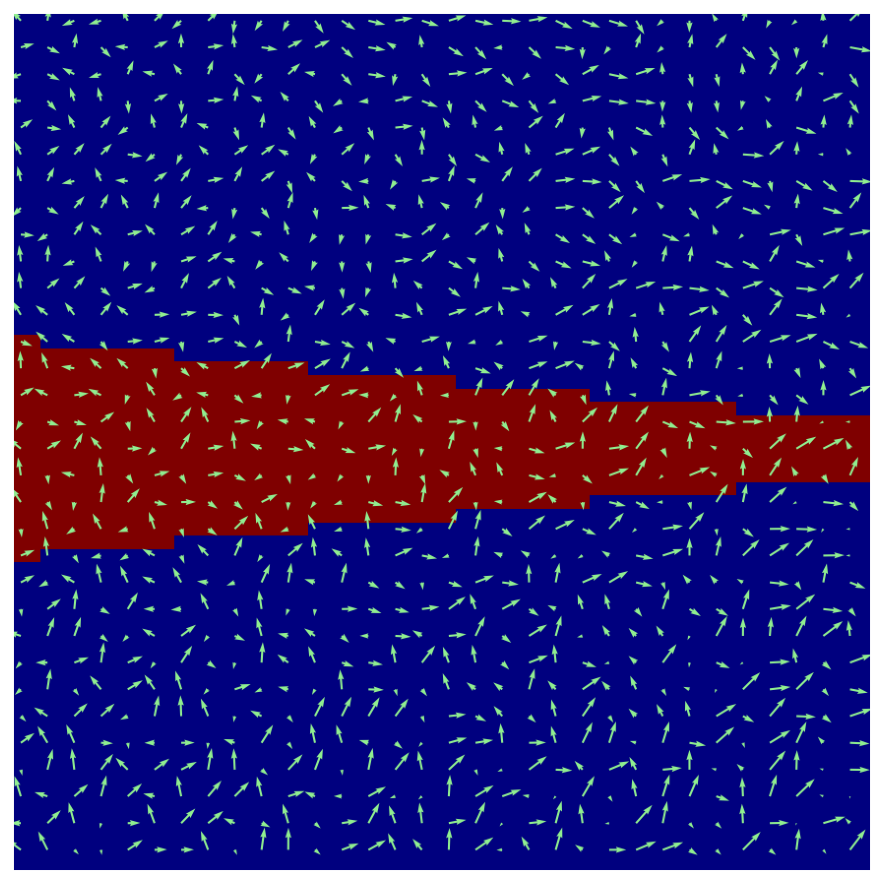

In [24]:
plt.figure(num=1234, figsize=(16, 16))
plt.imshow(_a_)
plt.axis('off')